# Classification with a Perceptron
In this notebook, we will investigate a classification problem using a Perceptron.

**Learning Objectives**
By the end of this notebook, you should be able to:
1. Describe how binary classification is a natural extension to the linear regression problem.
2. Write a Perceptron model to classify points in a binary classification.
3. Implement a Python class for classification with a Perceptron.

**Import modules**

Begin by importing the modules to be used in this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Polygon
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

### A Classification Problem
Consider a dataset with classified labels. In other words, the data has a set of parameters in $x_{data}$ and $y_{data}$ with a classification $c_{data}$ corresponding to each point. As an example, we will consider data you might collect from an upward-looking camera deployed in the shallow waters of the Monterey Bay coastal zone. From this data, you could imagine that you would have many images of sea lions - a common marine mammal in the area, much like the one here:

<img src="Sea_Lion_From_Below.png" alt="Photo of a Sea Lion from below" width="500">

From images captured by the camera, you can measure lots of different size metrics for the sea lion passing by, such as the skull length ($x_{data}$, mm) and the overall length ($y_{data}$, in cm). Then, the classifications may pertains to sex of the sea lion - class 0 male sea lions and class 1 for female sea lions.

In this case, we are looking to create a model to answer the following question: *given measurements of a sea lion's skull length and overall length from underwater photography, what is its sex?*

One such dataset for California sea lions is available in the paper [HERE](https://www.sciencedirect.com/science/article/pii/S0960982223004748), which we can read in as follows:

In [2]:
# read in the two data frames
df_male = pd.read_csv('male_sea_lion_measurements.csv')
df_female = pd.read_csv('female_sea_lion_measurements.csv')

# concatenate the dataframes
df = pd.concat([df_male, df_female])

# drop nans
df = df.dropna()

# print out the data frame
df

,CAS #,Field #,Locality,County,Sex,Year,SL,CBL,PL,MSW,MW,ML,MFL,MA,RPL,SSI,RMW,CBL/SL
0,MAM 26225,RB 4405,Point Reyes National Seashore,Marin,Male,1998,211.0,292.16,122.32,162.82,147.30,203.18,81.52,0.40,0.42,0.56,0.50,1.38
1,MAM 25929,RB 2897,Ano Nuevo Point,San Mateo,Male,1980,244.0,283.54,114.72,157.52,144.68,197.86,78.58,0.40,0.40,0.56,0.51,1.16
2,MAM 34681,RB 3898,"Pacifica, Linda Mar, San Pedro Valley Beach",San Mateo,Male,1995,239.0,296.12,127.84,163.44,148.54,208.54,67.86,0.33,0.43,0.55,0.50,1.24
3,MAM 34734,RB 5597,"Daly City, Thornton Beach",San Mateo,Male,2005,228.0,290.42,131.52,153.64,143.12,200.48,67.32,0.34,0.45,0.53,0.49,1.27
4,MAM 34735,RB 5663,"Daly City, north end of Thornton Beach.",San Mateo,Male,2005,239.0,277.62,120.14,158.92,139.44,195.44,66.78,0.34,0.43,0.57,0.50,1.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,MAM 23000,IS51,"Ft. Ross, in front of Salt Point Lodge",Sonoma,Female,1985,160.0,225.85,82.55,116.95,98.11,147.20,49.10,0.33,0.37,0.52,0.43,1.41
62,MAM 23173,MMC1152CSL,"Pacific Grove, Ocean View Blvd., between Acrop...",Monterey,Female,1990,158.0,230.17,89.44,124.13,104.26,149.08,50.52,0.34,0.39,0.54,0.45,1.46
63,MAM 23749,MMC1809CSL,"El Granada, Pillar Point Harbor",San Mateo,Female,1992,154.0,224.12,84.88,116.99,96.93,147.42,49.39,0.34,0.38,0.52,0.43,1.46
64,MAM 23760,MMC1845CSL,"Seacliff Beach, Cement Ship",Santa Cruz,Female,1992,158.0,235.08,96.27,117.20,98.71,156.60,50.67,0.32,0.41,0.50,0.42,1.49


To use the classification data numerically in our example, let's assign 0 to the males and 1 to the females

In [3]:
# add a classification column
df['Classification'] = 1
df.loc[df['Sex']=='Male', 'Classification'] = 0

There's a lot of good morphometric data in the above dataset, but for this example, we will investigate two distinguishing features for our sea lions - the skull length (condylobasal length, CBL) and standard body length (SL). Let's have a look at this data:

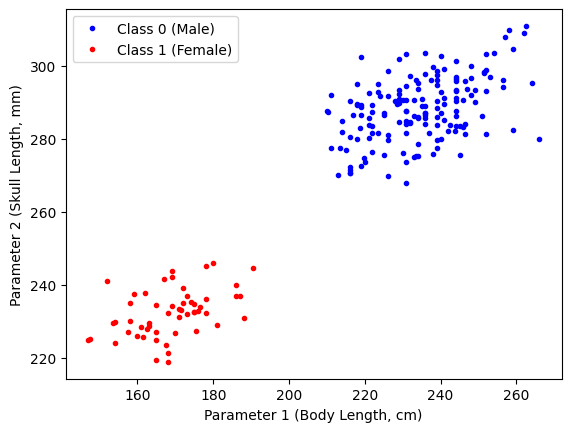

In [4]:
plt.plot(df['SL'][df['Classification']==0], df['CBL'][df['Classification']==0], 'b.', label="Class 0 (Male)")
plt.plot(df['SL'][df['Classification']==1], df['CBL'][df['Classification']==1], 'r.', label="Class 1 (Female)")
plt.xlabel("Parameter 1 (Body Length, cm)")
plt.ylabel("Parameter 2 (Skull Length, mm)")
plt.legend()
plt.show()

As we can see in the above data, the magnitudes of the parameters are quite large. To help with the construction of our model, let's standardize our data as we did in our multiple regression notebook:

In [5]:
df['SL_norm'] = (df['SL'] - np.mean(df['SL'])) / np.std(df['SL'])
df['CBL_norm'] = (df['CBL'] - np.mean(df['CBL'])) / np.std(df['CBL'])

As always, let's see what our data looks like:

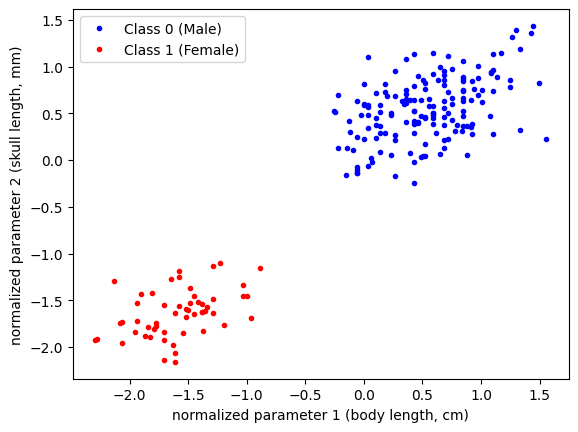

In [6]:
plt.plot(df['SL_norm'][df['Classification']==0],
         df['CBL_norm'][df['Classification']==0],'b.',label='Class 0 (Male)')
plt.plot(df['SL_norm'][df['Classification']==1],
         df['CBL_norm'][df['Classification']==1],'r.',label='Class 1 (Female)')
plt.xlabel('normalized parameter 1 (body length, cm)')
plt.ylabel('normalized parameter 2 (skull length, mm)')
plt.legend(loc=2)
plt.show()

Since we're going to be plotting the same dataset a few times, let's define a common set of bounds for our axes:

In [7]:
# define some bounds to be used in the plots below
min_x = -3
max_x = 3
min_y = -3
max_y = 3

In this example, we are going to consider defining a classification based on our two classes as follows:

$$
C = \begin{cases}
    1 & \text{if } b + w_1x_1 + w_2x_2  > 0 \\
    0   & \text{otherwise }
\end{cases}
$$

If we consider $x_2$ to be the $y$ axis of our plot, then we can visualize this classification as being 1 above the line

$$
x_2 = -\frac{w_1}{w_2}x_1 - \frac{b}{w_2}
$$

This formulation is termed an **activation function** and we can code it up as follows:

In [11]:
def activation_function(weights, x_1, x_2):
    classifications_model = np.zeros_like(x_1)
    class_1_indices = weights[0] + x_1*weights[1] + x_2*weights[2] > 0
    classifications_model[class_1_indices] = 1
    return classifications_model


Let's take a look an an example. Suppose we had the following initial guess for our normalized data:

In [9]:
w_1 = -0.12
w_2 = 0.1
b = 0.05

weights = np.array([b, w_1, w_2])

Plotting the classification "model" (i.e. the dividing line) would give the following:

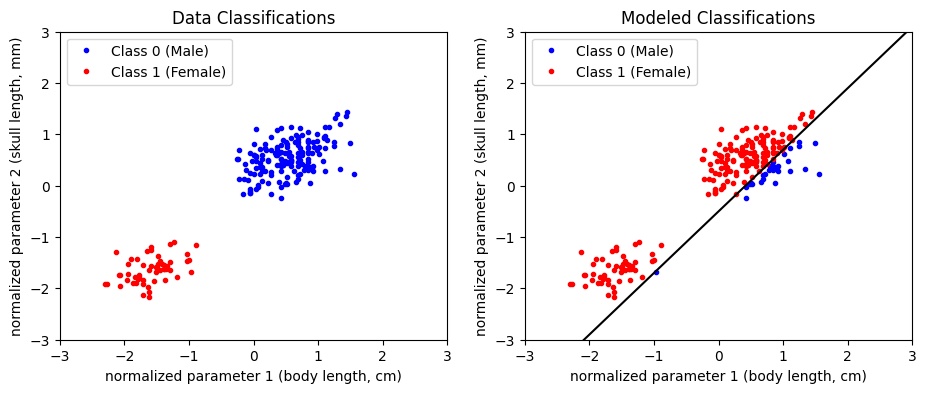

In [12]:
classifications_model = activation_function(weights, df['SL_norm'], df['CBL_norm'])

plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
# plot the data 
plt.plot(df['SL_norm'][df['Classification']==0],
         df['CBL_norm'][df['Classification']==0],'b.',label='Class 0 (Male)')
plt.plot(df['SL_norm'][df['Classification']==1],
         df['CBL_norm'][df['Classification']==1],'r.',label='Class 1 (Female)')

# format the axes
plt.gca().set_xlim([min_x,max_x])
plt.gca().set_ylim([min_y,max_y])
plt.legend(loc=2)
plt.title('Data Classifications')
plt.xlabel('normalized parameter 1 (body length, cm)')
plt.ylabel('normalized parameter 2 (skull length, mm)')

plt.subplot(1,2,2)
# plot the data as classified by the model
plt.plot(df['SL_norm'][classifications_model==0],
         df['CBL_norm'][classifications_model==0],'b.',label='Class 0 (Male)')
plt.plot(df['SL_norm'][classifications_model==1],
         df['CBL_norm'][classifications_model==1],'r.',label='Class 1 (Female)')

# plot the model dividing line
plot_x = np.linspace(min_x,max_x,100)
plt.plot(plot_x, plot_x*(-weights[1]/weights[2])-weights[0]/weights[2], 'k-')

# format the axes
plt.gca().set_xlim([min_x,max_x])
plt.gca().set_ylim([min_y,max_y])
plt.legend(loc=2)
plt.title('Modeled Classifications')
plt.xlabel('normalized parameter 1 (body length, cm)')
plt.ylabel('normalized parameter 2 (skull length, mm)')

plt.show()

Given this model guess, we could compute the loss depending on how many classifications we got wrong. Turns out, the mean square error loss function will give us just that!

In [13]:
def loss_function(classification_data, classification_model):
    error = np.sum((classification_data - classification_model)**2)
    return error

In [14]:
classifications_data = df['Classification']
classifications_model = activation_function(weights, df['SL_norm'], df['CBL_norm'])

print('Loss: '+str(loss_function(classifications_data,
                                 classifications_model))+' incorrect classifications')

Loss: 134.0 incorrect classifications


Depending on the initial guess for the intercept and slope, we probably don't have a very good model. The idea here is to move through the error space to determine how we should update the parameters and get a better classification model.

<img src="Perceptron_Schematic.png" alt="Schematic of a Perceptron" width="500">

Similar to gradient decent optimization for linear regression, we can define an approach to update our model weights based on new data. First, let's define a learning rate and first guess.

In [15]:
learning_rate = 0.001
w_1 = -0.12
w_2 = 0.1
b = 0.05
weights = np.array([b, w_1, w_2])

One update to the model can be made by computing the classification at a given data point and determining the how the weights should be updated. This is done according to the *Perceptron learning rule* which is very similar to the updates used for our linear regression problem:

$$
\begin{align*}
b &= b + \eta (c_i -\hat{c}_i)\\
w_1 &= w_1 + \eta (c_i -\hat{c}_i)x_{1,i}\\
w_2 &= w_2 + \eta (c_i -\hat{c}_i)x_{2,i}\\
\end{align*}
$$

Let's take a look at couple examples:

In [18]:
# compute the modeled values

for data_point in range(159, 165):
    classification_data = df['Classification'].iloc[data_point]
    classification_model = activation_function(weights, df['SL_norm'].iloc[data_point], df['CBL_norm'].iloc[data_point])

    print("Data: ", classification_data, "Model: ", classification_model)
    if classification_data != classification_model:
        b_update = learning_rate * (classification_data-classification_model)
        w1_update = learning_rate * (classification_data-classification_model)* df['SL_norm'].iloc[data_point]
        w2_update = learning_rate * (classification_data-classification_model)* df['CBL_norm'].iloc[data_point]
        print('     b update: ', b_update)
        print('     w1 update: ', w1_update)
        print('     w2 update: ', w2_update)

Data:  0 Model:  1.0
     b update:  -0.001
     w1 update:  -0.0002638356349165641
     w2 update:  0.00016773714577915957
Data:  0 Model:  0.0
Data:  1 Model:  1.0
Data:  1 Model:  1.0
Data:  1 Model:  0.0
     b update:  0.001
     w1 update:  -0.0009658199974243502
     w2 update:  -0.001686450351532054
Data:  1 Model:  1.0


As we can see, the parameters are only updated when the model classification does not match the data classification.

Just as we did with our linear regression example, we can build a slider widget to examine how this would look over many iterations

In [19]:
def plot_fit_and_cost(initial_guess, n_iterations):

    weights = np.copy(initial_guess)
    for n in range(n_iterations):
        i = n%len(df)
        iteration = n//len(df)
        classification_data = df['Classification'].iloc[i]
        classification_model = activation_function(weights,
                                            df['SL_norm'].iloc[i],
                                            df['CBL_norm'].iloc[i])
        weights[0] += learning_rate*(classification_data - classification_model)
        weights[1] += learning_rate*(classification_data - classification_model)*df['SL_norm'].iloc[i]
        weights[2] += learning_rate*(classification_data - classification_model)*df['CBL_norm'].iloc[i]
        
    classifications_model = activation_function(weights, df['SL_norm'], df['CBL_norm'])
    classifications_data = df['Classification']
    errors = np.sum(np.abs(classifications_model-classifications_data))
    
    fig = plt.figure(figsize=(5,5))
    
    plt.plot(df['SL_norm'][classifications_model==0],
         df['CBL_norm'][classifications_model==0],'b.',label='Class 0 (Male)')
    plt.plot(df['SL_norm'][classifications_model==1],
         df['CBL_norm'][classifications_model==1],'r.',label='Class 1 (Female)')
    plot_x = np.linspace(min_x,max_x,100)
    plt.plot(plot_x, plot_x*(-weights[1]/weights[2])-weights[0]/weights[2], 'k-')
    plt.title('Fit after data point '+str(n)+' in iteration '+str(iteration)+', Errors: '+str(errors))
    plt.gca().set_xlim([min_x,max_x])
    plt.gca().set_ylim([min_y,max_y])
    plt.legend(loc=2)
    plt.ylabel('y')
    plt.xlabel('x')

    plt.show()

In [21]:
interact(plot_fit_and_cost, initial_guess=fixed(np.array([b, w_1, w_2])),
         n_iterations=widgets.IntSlider(min=1, max=2000))

interactive(children=(IntSlider(value=1, description='n_iterations', max=2000, min=1), Output()), _dom_classes…

<function __main__.plot_fit_and_cost(initial_guess, n_iterations)>

As you probably noticed in the previous example, the updates to the model become slower and slower because there are fewer and fewer misclassifications as we move through the data set.

# Perceptron as a Class

Building on the framework we've seen earlier for the linear regression problems, we can also create a Python class for our perceptron that can be applied to a wide range of data:

In [22]:
class Perceptron:
    def __init__(self, X, learning_rate=0.01, n_iters=1000, random_seed=1):
        """
        Parameters:
        - X: Training data matrix (num_samples x num_features)
        - learning_rate: Step size for weight updates
        - n_iters: Number of training iterations
        - random_seed: Seed for reproducibility
        """
        self.lr = learning_rate
        self.n_iters = n_iters
        self.random_seed = random_seed
        self.initialize(X)
        

    def initialize(self, X):
        """
        Initializes the weight vector with small random values.
        """
        np.random.seed(self.random_seed)
        self.w = np.random.normal(loc=0.0, scale=0.01, size=np.shape(X)[1])

    def activation(self, x):
        """Binary step activation function"""
        classification = np.where(x>0, 1, 0)
        return classification

    def fit(self, X, c):
        """Train the perceptron using the perceptron learning rule"""
        for iteration in range(self.n_iters):
            for xi, target in zip(X, c):
                linear_output = np.dot(xi, self.w)
                c_pred = self.activation(linear_output)
                update = self.lr * (target - c_pred)
                self.w += update*xi
                
    def predict(self, X):
        """Predict binary labels for input data"""
        linear_output = np.dot(X, self.w)
        return self.activation(linear_output)

Now, we can use our class to make a model object and fit it to our data:

In [23]:
X = np.column_stack([np.ones_like(df['SL_norm']), df['SL_norm'], df['CBL_norm']])
model = Perceptron(X)
model.fit(X, df['Classification'])

Let's see how our model did. First, we use it to make some classifications:

In [26]:
classifications_model = model.predict(X)

and then we can plot the classifications to see how we did:

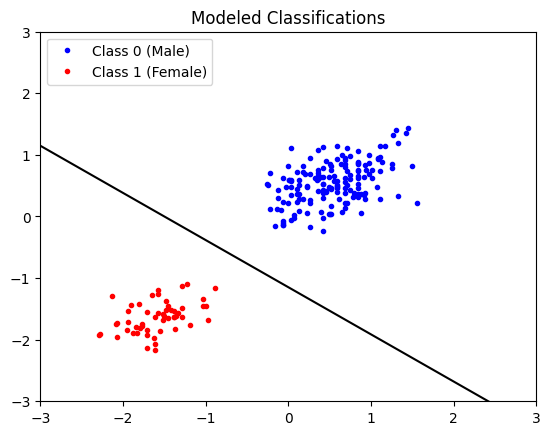

In [30]:
plt.plot(df['SL_norm'][classifications_model==0],
         df['CBL_norm'][classifications_model==0],'b.',label='Class 0 (Male)')
plt.plot(df['SL_norm'][classifications_model==1],
         df['CBL_norm'][classifications_model==1],'r.',label='Class 1 (Female)')

# plot the model dividing line
plot_x = np.linspace(min_x,max_x, 100)
plt.plot(plot_x, (-model.w[1]/model.w[2])*plot_x + (-model.w[0]/model.w[2]), 'k-')

# format the axes
plt.gca().set_xlim([min_x,max_x])
plt.gca().set_ylim([min_y,max_y])
plt.legend(loc=2)
plt.title('Modeled Classifications')

plt.show()

Looks good! Be sure to compare and contrast this solution with the one shown above.

**Key Takeaways**

1. The Perceptron model is similar to the linear regression model, but employs an activation function for classification

2. The Perceptron model's parameters can be learned by feeding in data until the model has converged.

3. The Perceptron model can be implemented in a Python class which is nearly identical to linear regression.